In [1]:
import torch

# create compute function

def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [2]:
# scalar inputs as well as rank 1 and rank 2 inputs
print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))

print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))

print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


In [3]:
# create tensors that store gradients

a = torch.tensor(3.14, requires_grad=True)

print(a)

b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [4]:
w = torch.tensor([1.0, 2.0, 3.0])

print(w.requires_grad)

w.requires_grad_()

print(w.requires_grad)

False
True


In [5]:
# initialize tensor of 2x3 using glorot (xavier) initialization

import torch.nn as nn

torch.manual_seed(1)

w = torch.empty(2, 3)

nn.init.xavier_normal_(w)

print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [6]:
# two Tensor objects inside base nn.Module class

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.w1 = torch.empty(2, 3, requires_grad=True)

        nn.init.xavier_normal_(self.w1)

        self.w2 = torch.empty(1, 2, requires_grad=True)

        nn.init.xavier_normal_(self.w2)

In [7]:
# create tensors that require computing gradients for z = wx + b

w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])

z = torch.add( torch.mul( w, x ), b )

loss = (y-z).pow(2).sum()

loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [8]:
# verify computing of gradient for dL/dw

print( 2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


In [9]:
# -2(y -wx - b )
#  2(wx + b - y)

print( 2 * (( w * x + b ) - y))

tensor([-0.4000], grad_fn=<MulBackward0>)


In [10]:
# build a model with 2 densely (fully) connected layers using nn.Sequential

model = nn.Sequential( nn.Linear(4, 16), nn.ReLU(), nn.Linear(16, 32), nn.ReLU())

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [11]:
# configure first fully connected layer with initial value distribution for weight
# also configure second layer by computing L1 penalty

nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [12]:
# SGD optimizer with cross-entropy loss for binary classification
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

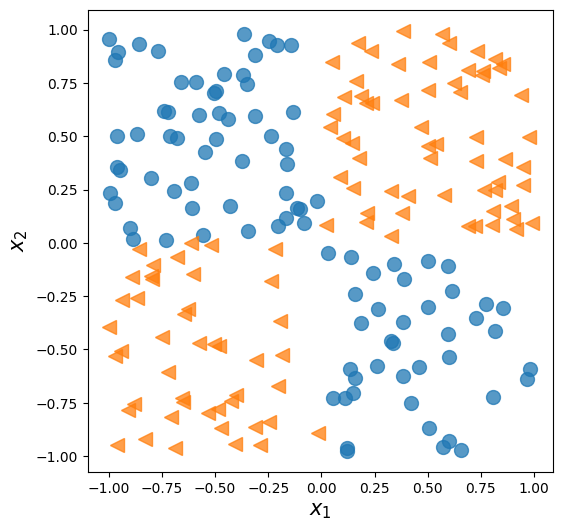

In [13]:
# generate toy dataset for XOR classification
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)

np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200,2))

y = np.ones(len(x))

y[x[:, 0] * x[:, 1] < 0 ] = 0

n_train = 100

x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train],    dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:],    dtype=torch.float32)

fig = plt.figure(figsize=(6,6))

plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)

plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

In [14]:
# create data loader that uses a batch size of 2 for the training data
from torch.utils.data import DataLoader, TensorDataset
 
    
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [15]:
# good idea to start with a simple model for a baseline such as
# a single-layer NN with logistic regression

model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [16]:
# initialize cross entropy loss function and SSGD optimizer

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [17]:
# train model for 200 epochs and record history
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

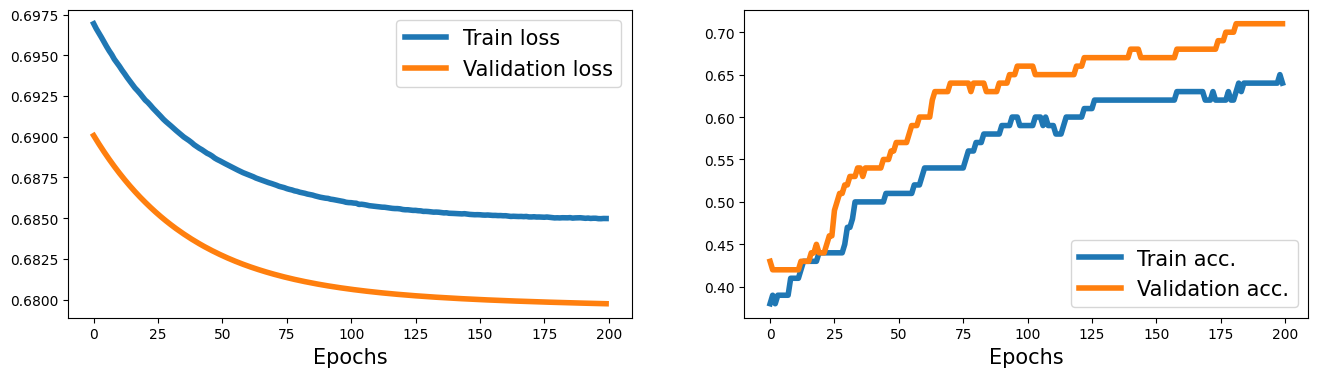

In [18]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_03.png', dpi=300)

In [19]:
# feedforward NN with 2 hidden layers
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [20]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

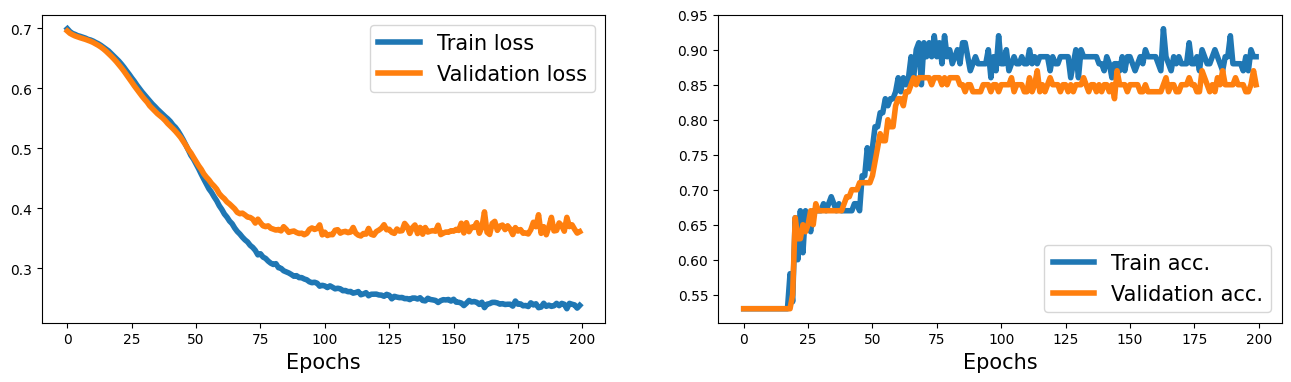

In [21]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_04.png', dpi=300)

In [22]:
# define custom class by extending nn.Module 

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [23]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [24]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


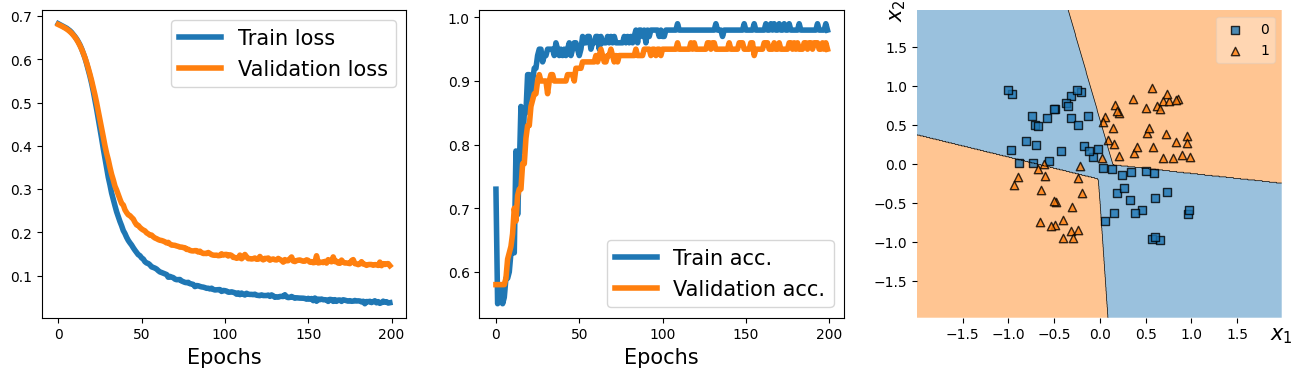

In [25]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()

In [26]:
# create custom noisy layer that computates w(x+e) + b

class NoisyLinear(nn.Module):

    def __init__(self, input_size, output_size, noise_stddev=0.1):

        super().__init__()

        w = torch.Tensor(input_size, output_size)

        self.w = nn.Parameter(w) # nn.Parameter is a Tensor that's a module parameter

        nn.init.xavier_uniform_(self.w)

        b = torch.Tensor(output_size).fill_(0)

        self.b = nn.Parameter(b)

        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):

        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)

            x_new = torch.add(x, noise)

        else:
            x_new = x

        return torch.add( torch.mm(x_new, self.w), self.b)

In [27]:
# test noisy layer
# define instance of layer and call it 3 times on same input layer

torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)

x = torch.zeros((1, 4))

print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))

print(noisy_layer(x, training=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [28]:
# create new model using NoisyLinear layer
class MyNoisyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)

        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)

        pred = self.forward(x)[:, 0]

        return (pred >= 0.5).float()
    
torch.manual_seed(1)

model = MyNoisyModule()

model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [29]:
# train model

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist_train[epoch] += loss.item()
        
        is_correct = (
            (pred >= 0.5).float() == y_batch
        ).float()

        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= 100 / batch_size
    accuracy_hist_train[epoch] /= 100/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)

    loss_hist_valid[epoch] = loss.item()

    is_correct = ((pred >= 0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

C:\Users\Andrew Solis\AppData\Local\Temp\ipykernel_11120\3754970553.py:25: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.integer), clf=model)


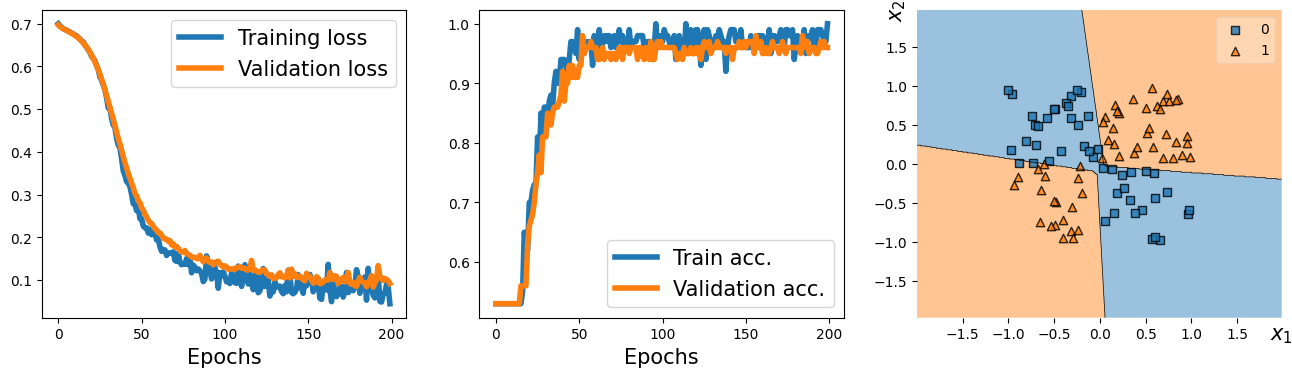

In [30]:
# plot losses, accuracies, and decision boundary

fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 3, 1)

plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)

plt.legend(['Training loss', 'Validation loss'], fontsize=15)

ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)

plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)

plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)

ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)

plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.integer), clf=model)

ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## Project One - Predicting Fuel Efficiency of Car

In [31]:
# import MPG data, drop incomplete rows, partition dataset, standardize features

import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

## drop NA rows
df = df.dropna()
df = df.reset_index(drop=True)

## train/test split
import sklearn
import sklearn.model_selection

df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=1)

train_stats = df_train.describe().transpose()

numeric_column_names = [
    'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration'
]

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std =  train_stats.loc[col_name, 'std']

    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean) / std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean) / std
    
df_train_norm.tail()

C:\Users\Andrew Solis\AppData\Local\Temp\ipykernel_11120\3030096239.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.8243028   0.3511267  -0.8243028  -0.8243028  -0.8243028   1.52655621
  0.3511267  -0.8243028  -0.8243028  -0.8243028   0.3511267  -0.8243028
  0.3511267   1.52655621  1.52655621  1.52655621  0.3511267   1.52655621
 -0.8243028   0.3511267   1.52655621 -0.8243028  -0.8243028   0.3511267
 -0.8243028  -0.8243028  -0.8243028   0.3511267  -0.8243028   1.52655621
  0.3511267  -0.8243028   0.3511267  -0.8243028  -0.8243028   1.52655621
 -0.8243028   1.52655621  1.52655621 -0.8243028  -0.8243028  -0.8243028
 -0.8243028   0.3511267  -0.8243028   1.52655621 -0.8243028  -0.8243028
  1.52655621 -0.8243028  -0.8243028  -0.8243028   1.52655621  1.52655621
  0.3511267   0.3511267   1.52655621 -0.8243028  -0.8243028   1.52655621
  1.52655621 -0.8243028  -0.8243028   0.3511267   1.52655621 -0.8243028
  0.35112

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


In [32]:
# separate model year into buckets

boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)

df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)

df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

In [33]:
# use one-hot encoding of NN for categorical feature to convert to dense format
from torch.nn.functional import one_hot

total_origin = len(set( df_train_norm['Origin']))

origin_encoded = one_hot( torch.from_numpy( df_train_norm['Origin'].values) % total_origin)

x_train_numeric = torch.tensor( df_train_norm[numeric_column_names].values)

x_train = torch.cat([ x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot( torch.from_numpy( df_test_norm['Origin'].values) % total_origin )

x_test_numeric = torch.tensor( df_test_norm[numeric_column_names].values )

x_test = torch.cat([ x_test_numeric, origin_encoded], 1).float()

In [34]:
# create label tensors for MPG values
y_train = torch.tensor( df_train_norm['MPG'].values).float()
y_test  = torch.tensor( df_test_norm['MPG'].values).float()

In [35]:
# create a data loader that uses a batch size of 8 for training data
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [36]:
# build model with 2 fully connected layers with 8 hidden units and another has 4

hidden_units = [8, 4]
input_size = x_train.shape[1]

all_layers = []

for hidden_unit in hidden_units:
    
    layer = nn.Linear( input_size, hidden_unit )

    all_layers.append(layer)
    all_layers.append(nn.ReLU())

    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))

model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [37]:
# use MSE for loss and SGD for optimization

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [38]:
# train for 200 epochs and display for every 20

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20

for epoch in range(num_epochs):

    loss_hist_train = 0

    for x_batch, y_batch in train_dl:

        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    if epoch % log_epochs == 0:

        print(f'Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}')

Epoch 0  Loss 536.1047
Epoch 20  Loss 8.4361
Epoch 40  Loss 7.8695
Epoch 60  Loss 7.1891
Epoch 80  Loss 6.7062
Epoch 100  Loss 6.7599
Epoch 120  Loss 6.3124
Epoch 140  Loss 6.6864
Epoch 160  Loss 6.7648
Epoch 180  Loss 6.2156


In [39]:
# evaluate on test dataset

with torch.no_grad():
    pred = model(x_test.float())[:, 0]

    loss = loss_fn(pred, y_test)

    print(f'Test MSE: {loss.item():.4f}')
    print(f'Test MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

Test MSE: 9.6133
Test MAE: 2.1211


## Project 2: MNIST handwritten digits

In [40]:
# load dataset and specify hyperparameters

import torchvision

from torchvision import transforms

image_path = './'

transform = transforms.Compose([transforms.ToTensor()])

mnist_train_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=False)

mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

batch_size = 64

torch.manual_seed(1)

train_dl = DataLoader( mnist_train_dataset, batch_size, shuffle=True)

In [41]:
## construct NN model

hidden_units = [32, 16]

image_size = mnist_train_dataset[0][0].shape

input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]

for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)

    all_layers.append(layer)
    all_layers.append(nn.ReLU())

    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))

model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [42]:
# use model for training, evaluation, and prediction

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.manual_seed(1)

num_epochs = 20

for epoch in range(num_epochs):
    accuracy_hist_train = 0
    
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)

        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        is_correct = ( torch.argmax( pred, dim=1) == y_batch).float()

        accuracy_hist_train += is_correct.sum()
    
    accuracy_hist_train /= len(train_dl.dataset)

    print(f'Epoch {epoch} Accuracy {accuracy_hist_train:.4f}')

Epoch 0 Accuracy 0.8531
Epoch 1 Accuracy 0.9287
Epoch 2 Accuracy 0.9413
Epoch 3 Accuracy 0.9506
Epoch 4 Accuracy 0.9558
Epoch 5 Accuracy 0.9592
Epoch 6 Accuracy 0.9627
Epoch 7 Accuracy 0.9650
Epoch 8 Accuracy 0.9674
Epoch 9 Accuracy 0.9690
Epoch 10 Accuracy 0.9710
Epoch 11 Accuracy 0.9729
Epoch 12 Accuracy 0.9739
Epoch 13 Accuracy 0.9750
Epoch 14 Accuracy 0.9764
Epoch 15 Accuracy 0.9777
Epoch 16 Accuracy 0.9779
Epoch 17 Accuracy 0.9798
Epoch 18 Accuracy 0.9806
Epoch 19 Accuracy 0.9813


In [43]:
# evaluate testing set

pred = model(mnist_test_dataset.data / 255.)

is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()

print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9647


## Pytorch lightning model

In [54]:
# Lightning model

import pytorch_lightning as pl
import torch
import torch.nn as nn

from torchmetrics import Accuracy

from torchmetrics import __version__ as torchmetrics_version
from pkg_resources import parse_version

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        super().__init__()
        
        # new PL attributes:
        
        if parse_version(torchmetrics_version) > parse_version("0.8"):
            self.train_acc = Accuracy(task="multiclass", num_classes=10)
            self.valid_acc = Accuracy(task="multiclass", num_classes=10)
            self.test_acc = Accuracy(task="multiclass", num_classes=10)
        else:
            self.train_acc = Accuracy()
            self.valid_acc = Accuracy()
            self.test_acc = Accuracy()
        
        # Model similar to previous section:
        input_size = image_shape[0] * image_shape[1] * image_shape[2] 
        all_layers = [nn.Flatten()]
        for hidden_unit in hidden_units: 
            layer = nn.Linear(input_size, hidden_unit) 
            all_layers.append(layer) 
            all_layers.append(nn.ReLU()) 
            input_size = hidden_unit 
 
        all_layers.append(nn.Linear(hidden_units[-1], 10)) 
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self, outs):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss
    
    def on_validation_epoch_end(self, outs):
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [55]:
# setup dataloadder using LightningDataModule

from pytorch_lightning.utilities.types import TRAIN_DATALOADERS
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms

class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        MNIST(root=self.data_path, download=True) 

    def setup(self, stage=None):
        # stage is either 'fit', 'validate', 'test', or 'predict'
        # here note relevant
        mnist_all = MNIST( 
            root=self.data_path,
            train=True,
            transform=self.transform,  
            download=False
        ) 

        self.train, self.val = random_split(
            mnist_all, [55000, 5000], generator=torch.Generator().manual_seed(1)
        )

        self.test = MNIST( 
            root=self.data_path,
            train=False,
            transform=self.transform,  
            download=False
        ) 

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=4)
    
    
torch.manual_seed(1) 
mnist_dm = MnistDataModule()

In [56]:
# train model
from pytorch_lightning.callbacks import ModelCheckpoint


mnistclassifier = MultiLayerPerceptron()

callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor="valid_acc")] # save top 1 model

if torch.cuda.is_available(): # if you have GPUs
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks, accelerator='gpu')
else:
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks, accelerator='cpu')

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | train_acc | MulticlassAccuracy | 0      | train
1 | valid_acc | MulticlassAccuracy | 0      | train
2 | test_acc  | MulticlassAccuracy | 0      | train
3 | model     | Sequential         | 25.8 K | train
---------------------------------------------------------
25.8 K    Trainable params
0         Non-trainable params
25.8 K    Total params
0.103     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 20.93it/s] 

TypeError: MultiLayerPerceptron.on_validation_epoch_end() missing 1 required positional argument: 'outs'